In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammainc

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape
X = digits.data

def plot_digits(data):
    n_rows = (data.shape[0] + 9) // 10
    fig, ax = plt.subplots(n_rows, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for i, axi in enumerate(ax.flat):
        if i >= data.shape[0]:
            break
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

In [3]:
import numbers
def check_random_state(seed):
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState instance')

In [8]:
VALID_KERNELS = ['gaussian', 'tophat']

class KernelDensity:
    def __init__(self, kernel='gaussian', bw_method=None):
        assert kernel in VALID_KERNELS
        self.bw_method = bw_method
        self.kernel = kernel
        
    def estimate_bandwidth(self):
        N, D = self.data_.shape
        
        if np.isscalar(self.bw_method) and not isinstance(self.bw_method, str):
            cov_factor = self.bw_method
        elif self.bw_method is None or self.bw_method == 'scott':
            cov_factor = np.power(N, -1 / (D + 4))
        elif self.bw_method == 'silverman':
            cov_factor = np.power(N * (D + 2.) / 4., -1 / (D + 4))

        return np.power(np.atleast_2d(cov_factor * np.std(self.data_, axis=0)), 2)
        
    def fit(self, X, y=None):
        self.data_ = X
        self.bandwidth_ = self.estimate_bandwidth()
        return self
    
    def sample(self, n_samples=1, random_state=None):
        N, D = self.data_.shape
        rng = check_random_state(random_state)
        indices = rng.choice(N, n_samples)        
        
        if self.kernel == 'gaussian':
            return np.atleast_2d(rng.normal(self.data_[indices], self.bandwidth_))
    
        elif self.kernel == 'tophat':
            X = rng.normal(size=(n_samples, D))
            s_sq = np.sqrt((X * X).sum(axis=1))
            correction = gammainc(0.5 * D, 0.5 * s_sq) ** (1. / D) * self.bandwidth_ / np.sqrt(s_sq)
            return self.data_[indices] + X * correction[:, np.newaxis]

In [14]:
kde = KernelDensity(bw_method=1, kernel='gaussian')
new_digits = kde.fit(X).sample(n_samples=80)

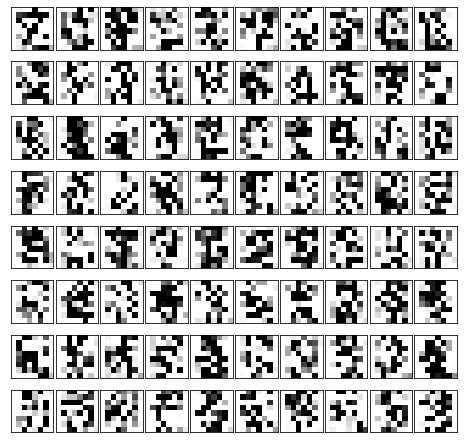

In [12]:
plot_digits(new_digits)